Participate in the design of an autonomous car
----------------

In this note book we discuss three segmentation models due to Divyam Gupta with respect to optimizer Adam: 

- Unet_mini, 
- Vgg_unet 
- Mobilenet_segnet


In order to this we fork the repository of Divyam Gupta in Github. 

In [ ]:
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
train_input_dir = '/content/drive/MyDrive/P08/train/images'
train_mask_dir = '/content/drive/MyDrive/P08/train/masks30'
train_target_dir = '/content/drive/MyDrive/P08/train/masks'
val_input_dir = '/content/drive/MyDrive/P08/val/images'
val_mask_dir = '/content/drive/MyDrive/P08/val/masks30'
val_target_dir = '/content/drive/MyDrive/P08/val/masks'
test_input_dir = '/content/drive/MyDrive/P08/test/images'
test_mask_dir = '/content/drive/MyDrive/P08/test/masks30'
test_target_dir = '/content/drive/MyDrive/P08/test/masks'
model_path = '/content/drive/MyDrive/P08/models'
checkpoint_path='/content/drive/MyDrive/P08/checkpoints'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of masks in 8 categories: ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of masks in 8 categories: ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of masks in 8 categories: ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2400  - Number of original masks:  2400  - Number of masks in 8 categories:  2400
/content/drive/MyDrive/P08/train/images/aachen_000000_000019.png

VAL -- Number of images:  575  - Number of original masks:  575  - Number of masks in 8 categories:  575
/content/drive/MyDrive/P08/val/images/stuttgart_000124_000019.png

TEST -- Number of images:  500  - Number of original masks:  500  - Number of masks in 8 categories:  500
/content/drive/MyDrive/P08/test/images/frankfurt_000000_000294.png


Function to plot the image and mask after prediction

In [ ]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=5):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

In [ ]:
#after forking the repostory import your repository
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/santra11/image-segmentation-keras.git
clear_output()


#### Import the models
from keras_segmentation.models.unet import unet_mini
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import mobilenet_segnet

In [ ]:
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 20
n_classes = 8
samples = len(train_input_path)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
score_IoU = tf.keras.metrics.MeanIoU(num_classes=8, name='mean_IoU')
epochs = 10

In [ ]:
# Prepare dataframe to compare the results
df_result = pd.DataFrame(
    columns= ['model',
              'epoch',
              'training_time',
              'freq_weighted_IoU',
              'mean_IoU',
              'void_IoU',
              'flat_IoU',
              'construction_IoU',
              'object_IoU',
              'nature_IoU',
              'sky_IoU',
              'human_IoU',
              'vehicule_IoU'])

In [ ]:
# Append model result to dataframe
def model_result_to_dataframe(model_name, epochs, training_time,  
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IoU"],
         'mean_IoU':model_result["mean_IoU"],
         'void_IoU':model_result["class_wise_IoU"][0],
         'flat_IoU':model_result["class_wise_IoU"][1],
         'construction_IoU':model_result["class_wise_IoU"][2],
         'object_IoU':model_result["class_wise_IoU"][3],
         'nature_IoU':model_result["class_wise_IoU"][4],
         'sky_IoU':model_result["class_wise_IoU"][5],
         'human_IoU':model_result["class_wise_IoU"][6],
         'vehicule_IoU':model_result["class_wise_IoU"][7]},
         ignore_index=True)
    
    return df_result

#### Unet mini model 

In [ ]:
# Name next model 
model_name= 'unet_mini'

# Call the model
model = unet_mini(n_classes=n_classes,
                        input_height=img_height,
                        input_width=img_width)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                           

Training for unet_mini
Verifying training dataset


100%|██████████| 2400/2400 [20:40<00:00,  1.93it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [04:21<00:00,  2.20it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 1075s 2s/step - loss: 1.0054 - score_IoU: 0.4325 - accuracy: 0.6724 - val_loss: 0.7698 - val_score_IoU: 0.4375 - val_accuracy: 0.7629
Epoch 2/10
512/512 [==============================] - 1111s 2s/step - loss: 0.5618 - score_IoU: 0.4336 - accuracy: 0.8220 - val_loss: 0.5828 - val_score_IoU: 0.4382 - val_accuracy: 0.8221
Epoch 3/10
512/512 [==============================] - 1072s 2s/step - loss: 0.4777 - score_IoU: 0.4355 - accuracy: 0.8491 - val_loss: 0.5242 - val_score_IoU: 0.4397 - val_accuracy: 0.8394
Epoch 4/10
512/512 [==============================] - 1073s 2s/step - loss: 0.4288 - score_IoU: 0.4372 - accuracy: 0.8646 - val_loss: 0.4622 - val_score_IoU: 0.4414 - val_accuracy: 0.8559
Epoch 5/10
512/512 [==============================] - 1111s 2s/step - loss: 0.3997 - score_IoU: 0.4385 - accuracy: 0.8735 - val_loss: 0.4328 - val_score_IoU: 0.4425 - val_accuracy: 0.8648
Epoch 6/10
512/512 [=====================

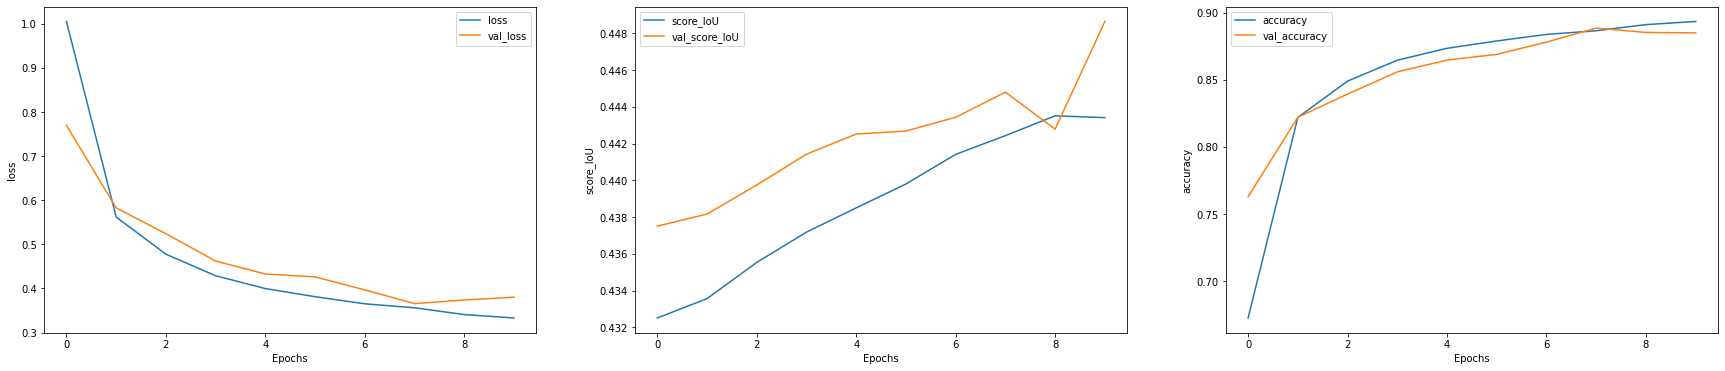

Training time : 12390.225490093231


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

# Evaluate the model

In [ ]:
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [05:14,  1.59it/s]

Evaluation time : 315.0633523464203


[ 55 233]


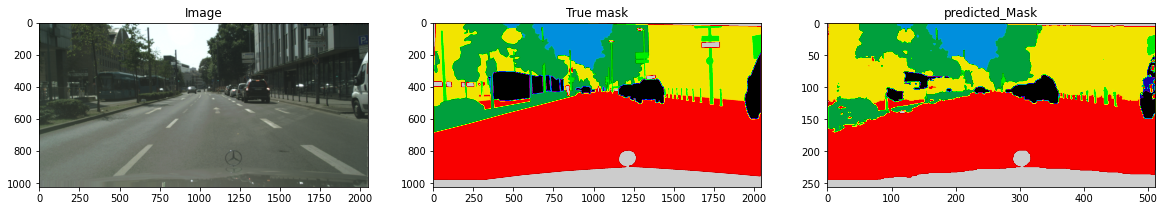

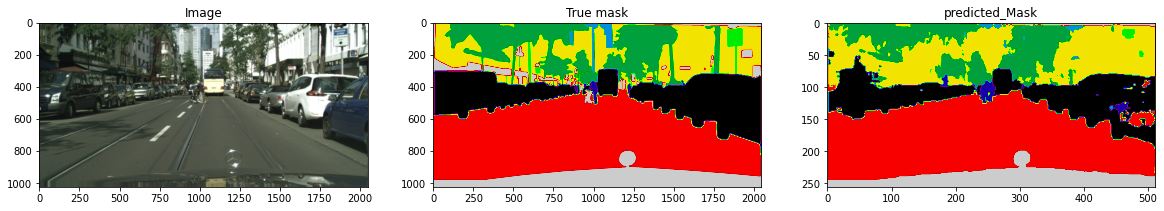

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

In [ ]:
df_result = pd.DataFrame(
    columns= ['model',
              'epoch',
              'training_time',
              'eval_time',
              'freq_weighted_IoU',
              'mean_IoU',
              'void_IoU',
              'flat_IoU',
              'construction_IoU',
              'object_IoU',
              'nature_IoU',
              'sky_IoU',
              'human_IoU',
              'vehicule_IoU'])

In [ ]:
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)
# Display result
df_result


,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,unet_mini,10,12390.22549,315.063352,0.778367,0.65137,0.65463,0.888437,0.725413,0.247886,0.820239,0.84073,0.370385,0.663241


####  Mobilenet Segnet model

In [ ]:
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

Training for mobilenet_segnet
Verifying training dataset


100%|██████████| 2400/2400 [03:18<00:00, 12.11it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [00:45<00:00, 12.54it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 969s 2s/step - loss: 0.3155 - score_IoU: 0.4407 - accuracy: 0.8965 - val_loss: 0.3543 - val_score_IoU: 0.4386 - val_accuracy: 0.8934
Epoch 2/10
512/512 [==============================] - 963s 2s/step - loss: 0.2020 - score_IoU: 0.4385 - accuracy: 0.9289 - val_loss: 0.3424 - val_score_IoU: 0.4405 - val_accuracy: 0.9061
Epoch 3/10
512/512 [==============================] - 957s 2s/step - loss: 0.1709 - score_IoU: 0.4407 - accuracy: 0.9389 - val_loss: 0.3918 - val_score_IoU: 0.4458 - val_accuracy: 0.9061
Epoch 4/10
512/512 [==============================] - 960s 2s/step - loss: 0.1600 - score_IoU: 0.4416 - accuracy: 0.9422 - val_loss: 0.4283 - val_score_IoU: 0.4660 - val_accuracy: 0.9044
Epoch 5/10
512/512 [==============================] - 955s 2s/step - loss: 0.1448 - score_IoU: 0.4452 - accuracy: 0.9473 - val_loss: 0.3750 - val_score_IoU: 0.4516 - val_accuracy: 0.9095
Epoch 6/10
512/512 [==========================

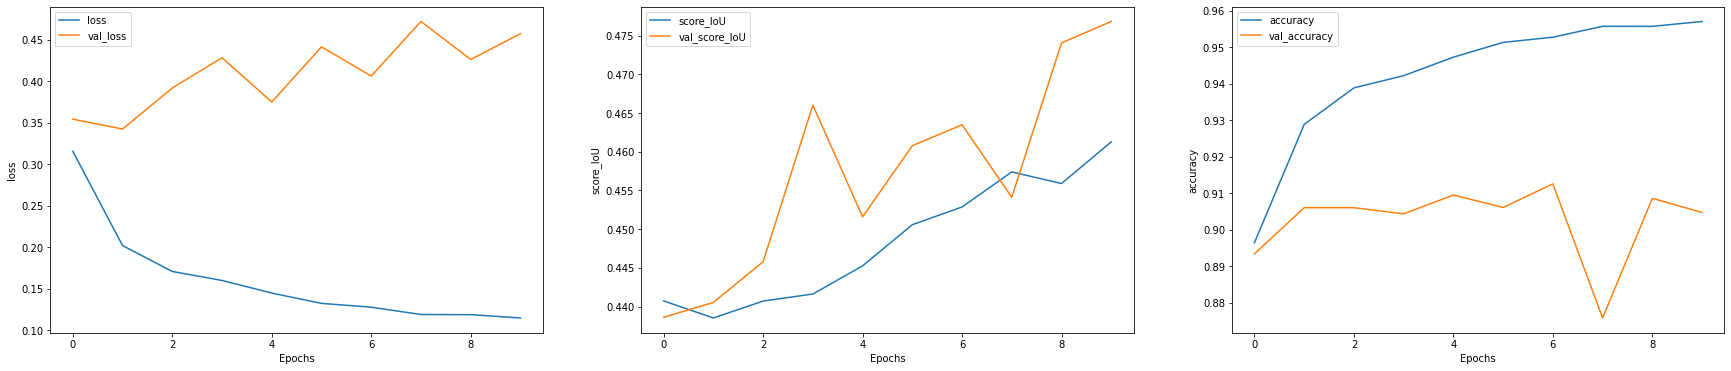

Training time : 9850.112735748291


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [01:24,  5.95it/s]

Evaluation time : 84.35953903198242


[214 292]


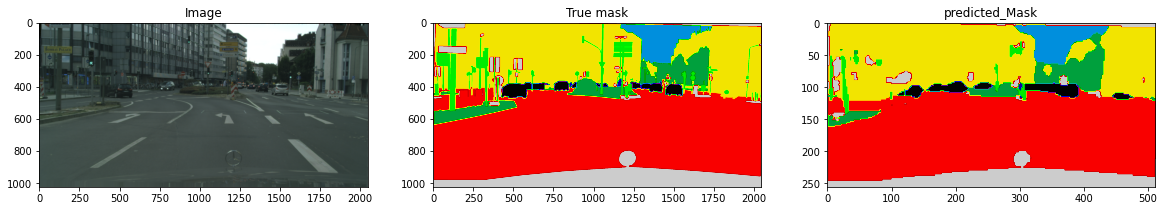

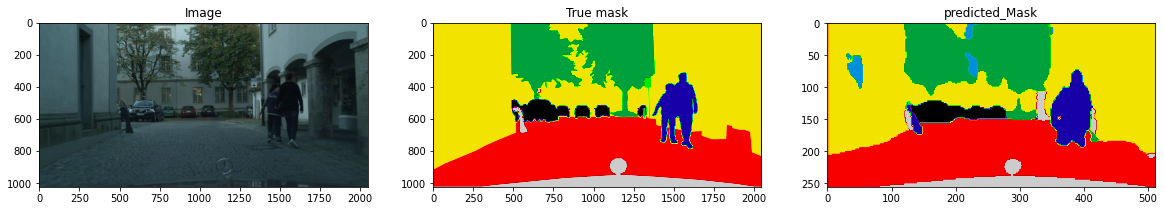

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

In [ ]:
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)
# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,unet_mini,10,12390.225490,315.063352,0.778367,0.65137,0.654630,0.888437,0.725413,0.247886,0.820239,0.840730,0.370385,0.663241
1,mobilenet_segnet,10,9850.112736,84.359539,0.808282,0.68723,0.652938,0.914996,0.789479,0.241131,0.806261,0.845768,0.484844,0.762420


#### VGG UNET model

In [ ]:
# Name next model to benchmark
model_name= 'vgg_unet'

# Call the model
model = vgg_unet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

Training for vgg_unet
Verifying training dataset


100%|██████████| 2400/2400 [03:17<00:00, 12.16it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 575/575 [00:46<00:00, 12.43it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 999s 2s/step - loss: 0.4984 - score_IoU: 0.4411 - accuracy: 0.8461 - val_loss: 0.3919 - val_score_IoU: 0.4375 - val_accuracy: 0.8786
Epoch 2/10
512/512 [==============================] - 980s 2s/step - loss: 0.2857 - score_IoU: 0.4376 - accuracy: 0.9080 - val_loss: 0.3099 - val_score_IoU: 0.4375 - val_accuracy: 0.9021
Epoch 3/10
512/512 [==============================] - 980s 2s/step - loss: 0.2320 - score_IoU: 0.4379 - accuracy: 0.9228 - val_loss: 0.3076 - val_score_IoU: 0.4378 - val_accuracy: 0.9012
Epoch 4/10
512/512 [==============================] - 976s 2s/step - loss: 0.1995 - score_IoU: 0.4383 - accuracy: 0.9320 - val_loss: 0.3126 - val_score_IoU: 0.4386 - val_accuracy: 0.9121
Epoch 5/10
512/512 [==============================] - 963s 2s/step - loss: 0.1724 - score_IoU: 0.4393 - accuracy: 0.9406 - val_loss: 0.3199 - val_score_IoU: 0.4391 - val_accuracy: 0.9091
Epoch 6/10
512/512 [==========================

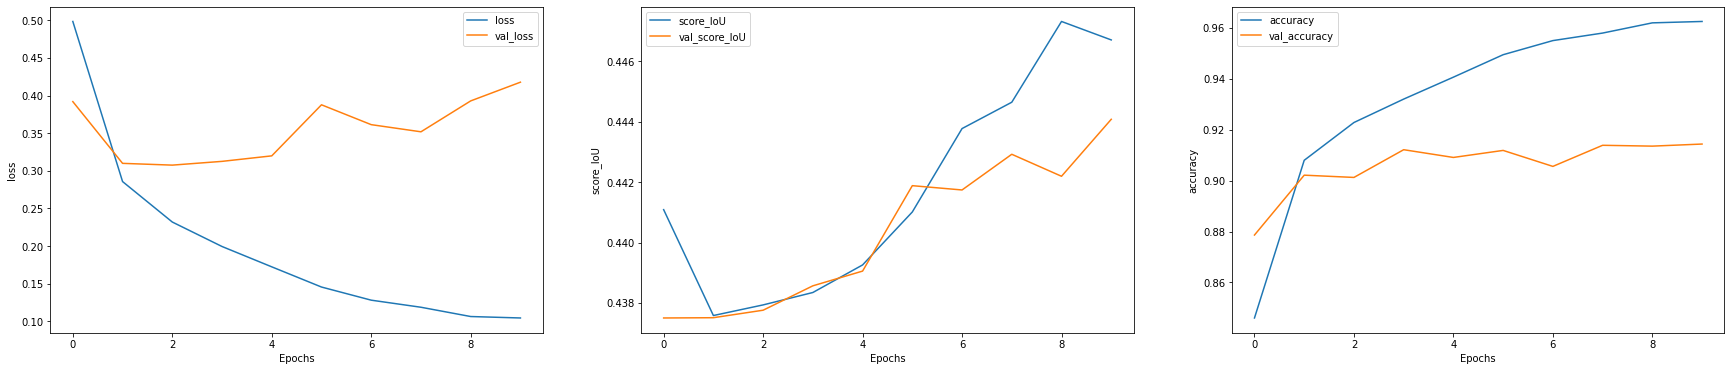

Training time : 9942.807960510254


In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

In [ ]:
# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [01:21,  6.12it/s]

Evaluation time : 82.00206136703491


[247 467]


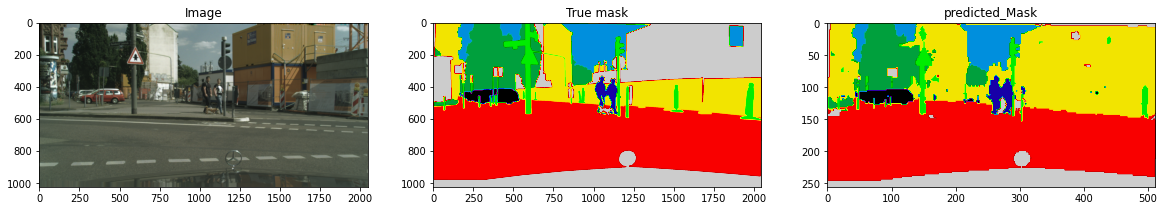

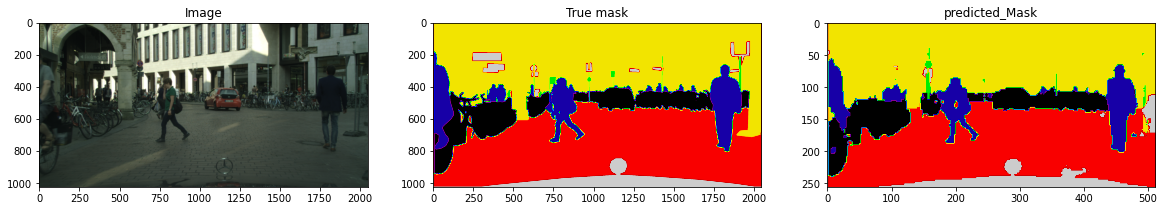

In [ ]:
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=2)

In [ ]:
#Comparison of the models 
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=False)
# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,unet_mini,10,12390.225490,315.063352,0.778367,0.651370,0.654630,0.888437,0.725413,0.247886,0.820239,0.840730,0.370385,0.663241
1,mobilenet_segnet,10,9850.112736,84.359539,0.808282,0.687230,0.652938,0.914996,0.789479,0.241131,0.806261,0.845768,0.484844,0.762420
2,vgg_unet,10,9942.807961,82.002061,0.827400,0.733696,0.657034,0.921149,0.797732,0.397157,0.850064,0.882717,0.570902,0.792813
